# Fit a Function with Keras TensorFlow

The [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that a neural network with at least one hidden layer can represent an arbitrarily complex function. This is similar to a Fourier series or Taylor series approximation. 

In this notebook we'll explore how to use Keras/TensorFlow to model an arbitrary function.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tonyreina/keras_tutorials/blob/master/lesson1_approximate_function/keras_tutorial_fit_function.ipynb)

## Define the libraries we want to use:  TensorFlow (includes Keras), NumPy, and Matplotlib

[Keras](http://keras.io) is the main API for defining neural network topologies in TensorFlow (as of TF 2.0).  

In [4]:
import tensorflow as tf   # Import TensorFlow
import numpy as np        # Import NumPy

In [5]:
import matplotlib.pyplot as plt   # Matplotlib: this allows us to plot things
%matplotlib inline

## Define the function we want to approximate with the TensorFlow model

In [6]:
def functionA(x):
    """
    Let's just define any type of function here for TensorFlow to approximate.
    Feel free to change this to whatever function you'd like to approximate.
    """
    
    return x**5 - x**3 + np.random.rand(len(x))*.01


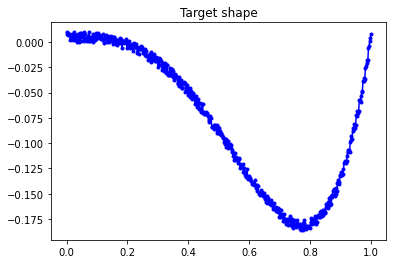

In [7]:
# Take some random points between 0 and 1 to evaluate the function
# We'll have a training set to fit the model and a test set to evaluate how well the model will generalize

# Create training set
N_train = 10000   # number of data points in training set
x_train = np.random.rand(N_train)  # Random points from 0 to 1
y_train = functionA(x_train)

# Create the test set
N_test = 500   # Number of data points in testing set
x_test = np.linspace(0, 1, N_test)  # In order N_test points from 0 to 1
y_test = functionA(x_test)

plt.plot(x_test, y_test, color="b", marker=".")
plt.title("Target shape");

# Define a neural network with Keras

This will be a Multilayered Perceptron (MLP) with a single input (the x value).  We want the output of the model to be the y value associated with that x (so it should approximate the function).

I highly recommend using the Keras [Functional API](https://keras.io/getting-started/functional-api-guide/) which is much more extensible than the Keras Sequential API.  The Functional API allows you create very complex topologies with multiple inputs/outputs, multiple paths, and skip connections.

In [8]:
inputs_to_model = tf.keras.layers.Input([1], name="myInput")   # There's just a single value input

# 1st hidden layer has 200 neurons and goes to a ReLU activation
layer1 = tf.keras.layers.Dense(units=200, name="myLayer1")(inputs_to_model)
activate1 = tf.keras.layers.Activation("relu")(layer1)

# 2nd hidden layer has 100 neurons and goes to a ReLU activation
layer2 = tf.keras.layers.Dense(units=100, name="yourLayer2")(activate1)
activate2 = tf.keras.layers.Activation("relu")(layer2)

# Output layer has 1 neuron (the predicted y value) and no activation
outputs_to_model = tf.keras.layers.Dense(units=1, name="myPrediction")(activate2)

## Tell Keras what inputs and outputs the model should expect

In [9]:
model = tf.keras.models.Model(inputs=[inputs_to_model], outputs=[outputs_to_model])

model.summary()  # Ask Keras to print the model summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
myLayer1 (Dense)             (None, 200)               400       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
yourLayer2 (Dense)           (None, 100)               20100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
myPrediction (Dense)         (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________

## Neural network math - aka never forget the bias unit

The equation is always the equation of a line (or hyperplane) 

$ y = mx + b $

or

$ output = \text{(units in layer + bias)} \times input $

_n.b._ The bias term can be brought inside the multiplication because we actually consider the input to the bias term as a constant 1.  This allows the network to learn the bias (which just becomes another weight to learn).

The __Dense__ layer is just a wrapper in Keras to define the TensorFlow operations for $ y = mx + b $.

Here's the math for the network we've created:

*myLayer1* has 200 units and takes *myInput* as the input layer.  

*myInput* has 1 unit, but we always have to add the bias term so it is actually 2 units.  That means there are 400 trainable parameters for *myLayer1*:

$ (1 + 1) \times 200 = 400 \text{ parameters for } \bf{myLayer1}$

*yourLayer2* has 100 units. The input is *activation* which has 200 units, but we always have the additional bias unit. So it is actually 201 units as input to *yourlayer2*.  This means there are 20,100 trainable parameters in *yourLayer2*.

$ (200 + 1) \times 100 =  20,100 \text{ parameters for } \bf{yourLayer2}$

*myPrediction* only has 1 unit. The input is *activation_2* which has 100 units, but we always have the additional bias unit. So it is actually 101 units as input to *myPrediction* for a total of 101 trainable parameters:

$ (100 + 1) \times 1 =  101 \text{ parameters for } \bf{myPrediction}$

![model_diagram](./keras_function_model.png)

## Compile the Keras model using MSE as the loss function and SGD as the optimizer

In [10]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss="mean_squared_error", optimizer=sgd)

## Train the compiled model on the training dataset for 10 epochs

Typically the more epochs the better results up until a certain point. After that you'll either not get any more benefit from training or you will overtfit to your training data. If you overfit, then the model will not do a good job on data it has never seen before (aka it won't generalize well).

In [11]:
number_of_epochs = 1
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test));

313/313 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0016


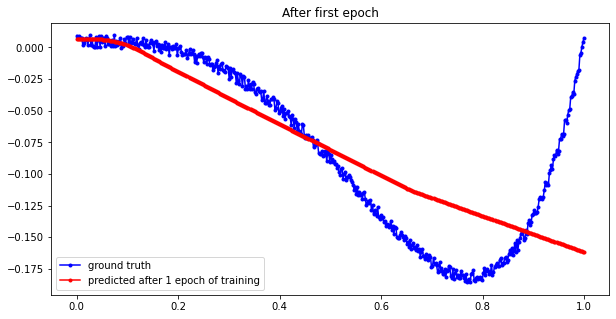

In [12]:
prediction_first1 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.title("After first epoch");
plt.legend(["ground truth", "predicted after 1 epoch of training"]);

In [13]:
number_of_epochs = 10
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test));

Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 9.6090e-04
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 8.7529e-04 - val_loss: 8.8849e-04
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 7.5867e-04 - val_loss: 7.1925e-04
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 6.3447e-04 - val_loss: 6.0517e-04
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 5.4299e-04 - val_loss: 5.1561e-04
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 4.6313e-04 - val_loss: 4.5449e-04
Epoch 10/10
313/313 [==============================] - 1

## Evaluate the trained model on the test dataset

In [14]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=10)

print(loss_and_metrics)

50/50 [==============================] - 0s 1ms/step - loss: 3.7679e-04
0.00037679230445064604


In [15]:
## Use the model to predict the test dataset

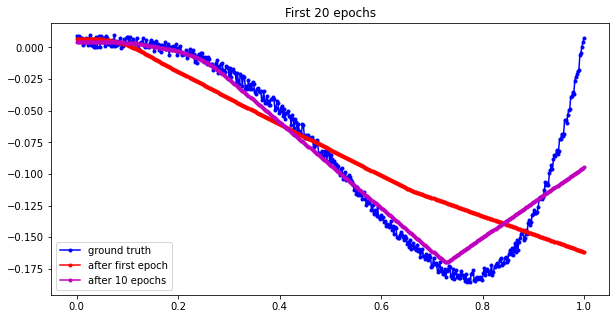

In [16]:
prediction_first10 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.title("First 20 epochs");
plt.legend(["ground truth", "after first epoch", "after 10 epochs"]);

## Let's do another 10 epochs and see how much better we can do

Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 3.4055e-04 - val_loss: 3.2699e-04
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 2.8902e-04 - val_loss: 2.7810e-04
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 2.4997e-04 - val_loss: 2.4105e-04
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 2.1846e-04 - val_loss: 2.0979e-04
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 1.9155e-04 - val_loss: 1.8544e-04
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 1.6879e-04 - val_loss: 1.6498e-04
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 1.5048e-04 - val_loss: 1.4507e-04
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 1.3351e-04 - val_loss: 1.2962e-04
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 1.2074e-04 - val_loss: 1.1787e-04
Epoch 10/10
313/313 [=======

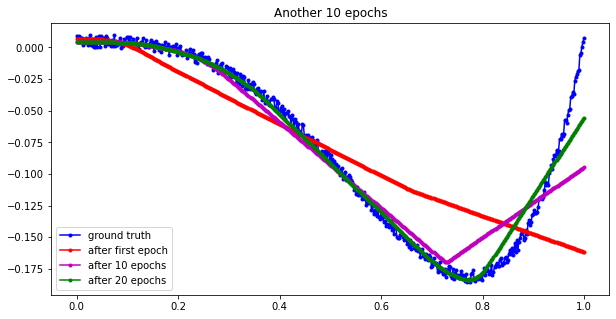

In [17]:
number_of_epochs = 10
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test))

prediction_second10 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.plot(x_test, prediction_second10, color="g", marker=".");
plt.title("Another 10 epochs");
plt.legend(["ground truth", "after first epoch", "after 10 epochs", "after 20 epochs"]);

Epoch 1/50
313/313 [==============================] - 1s 3ms/step - loss: 9.9245e-05 - val_loss: 9.8261e-05
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 9.1058e-05 - val_loss: 9.1231e-05
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 8.4124e-05 - val_loss: 8.5029e-05
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 7.7237e-05 - val_loss: 7.7619e-05
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 7.1765e-05 - val_loss: 7.2338e-05
Epoch 6/50
313/313 [==============================] - 1s 3ms/step - loss: 6.6768e-05 - val_loss: 6.7611e-05
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 6.2464e-05 - val_loss: 6.2928e-05
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 5.8457e-05 - val_loss: 5.8765e-05
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: 5.4731e-05 - val_loss: 5.5414e-05
Epoch 10/50
313/313 [=======

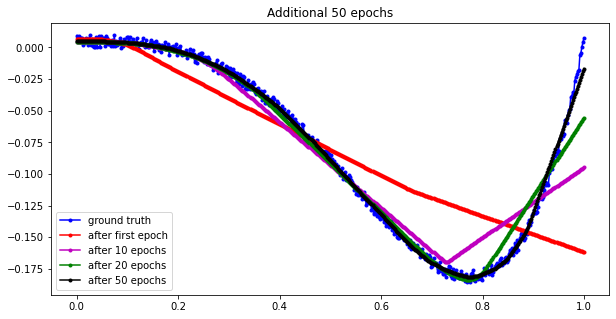

In [18]:
number_of_epochs = 50
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test))

prediction_additional50 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.plot(x_test, prediction_second10, color="g", marker=".");
plt.plot(x_test, prediction_additional50, color="k", marker=".");
plt.title("Additional 50 epochs")
plt.legend(["ground truth", "after first epoch", "after 10 epochs", "after 20 epochs", "after 50 epochs"]);

## Let's save this model to a file so that we can use it again

In [19]:
model.save("my_great_keras_model")  # Native TensorFlow "saved_model" format
#  model.save("my_great_keras_model.hdf5")  # Legacy Keras format

INFO:tensorflow:Assets written to: my_great_keras_model/assets


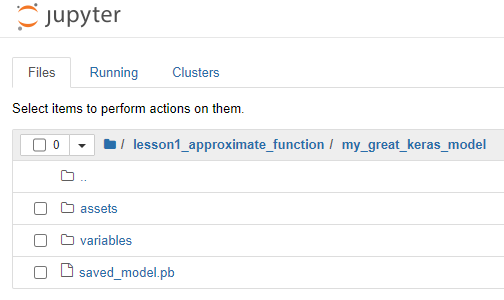

## You can use a model viewer like Netron to look at the model diagram

https://lutzroeder.github.io/netron/
    